# Configuração do dataset_path e montagem do Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/challenge_mottu2025/mottu_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configurações atualizadas

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 40 # Keeping the original higher epoch count for full training
NUM_CLASSES = 3

# Data Augmentation ajustado (usando os parâmetros reduzidos)

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.1,
    channel_shift_range=20.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Geradores atualizados

In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Verificação de classes e balanceamento
print("\nDistribuição de classes:")
print("Treino:", Counter(train_generator.classes))
print("Validação:", Counter(val_generator.classes))

Found 436 images belonging to 3 classes.
Found 98 images belonging to 3 classes.

Distribuição de classes:
Treino: Counter({np.int32(0): 159, np.int32(2): 139, np.int32(1): 138})
Validação: Counter({np.int32(0): 35, np.int32(2): 35, np.int32(1): 28})


# Visualização de amostras


Amosras aumentadas (visualização aproximada):


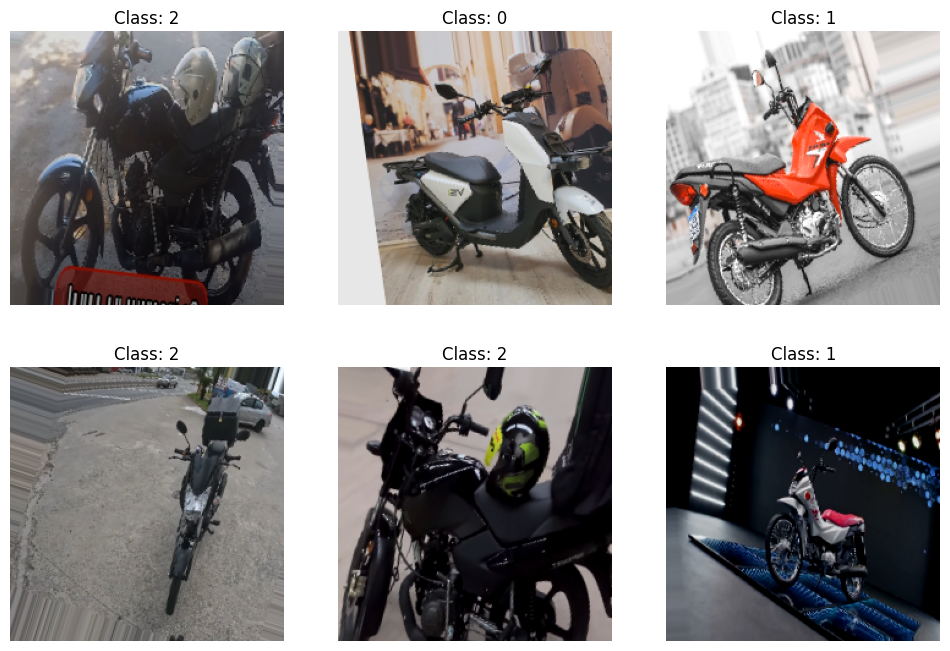

In [ ]:
def plot_augmented_images(generator, num_images=6):
    x, y = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        img = x[i].astype('float32')
        plt.subplot(2, 3, i+1)
        # EfficientNet preprocess_input scales pixel values, so we need to
        # un-scale them for visualization (simple division by 255 won't work
        # as the scaling is more complex). For visualization purposes,
        # we can just clip the values to the valid range [0, 255]
        # and convert to uint8. This is not ideal for true representation
        # but allows visualizing something.
        img_display = np.clip(img, 0, 255).astype('uint8')
        plt.imshow(img_display)
        plt.title(f"Class: {np.argmax(y[i])}")
        plt.axis('off')
    plt.show()

print("\nAmosras aumentadas (visualização aproximada):")
plot_augmented_images(train_generator)

# Callbacks melhorados

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * (10 ** (epoch / 10)))

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Treinamento em duas fases com fine-tuning ajustado

In [ ]:
print("\nFase 1 - Treinamento inicial")
history1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

# Fase 2: Fine-tuning com base descongelada
print("\nFase 2 - Fine-tuning")
# Determine the number of layers in the base model
total_base_layers = len(model.layers[0].layers)

# Choose the number of layers to unfreeze. Let's try unfreezing the last 30 layers for more fine-tuning.
num_unfreeze = 30
if num_unfreeze > total_base_layers:
    num_unfreeze = total_base_layers

print(f"Unfreezing the last {num_unfreeze} layers of the base model.")

# Access the base_model through the model
base_model = model.layers[0]

# Unfreeze the last num_unfreeze layers of the base model
for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True

# Keep the rest of the base model frozen
for layer in base_model.layers[:-num_unfreeze]:
    layer.trainable = False


# Compile the model again for fine-tuning with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary() # Check which layers are trainable

history2 = model.fit(
    train_generator,
    epochs=history1.epoch[-1] + 20, # Continue for another 20 epochs
    initial_epoch=history1.epoch[-1],
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)


Fase 1 - Treinamento inicial


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/28 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4437 - loss: 1.7550 - precision_4: 0.4114 - recall_4: 0.3316

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4856 - loss: 1.6458 - precision_4: 0.4732 - recall_4: 0.3839

28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4895 - loss: 1.6370 - precision_4: 0.4784 - recall_4: 0.3886 - val_accuracy: 0.7959 - val_loss: 1.0779 - val_precision_4: 0.8986 - val_recall_4: 0.6327
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8054 - loss: 0.9280 - precision_4: 0.8434 - recall_4: 0.7507

28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8059 - loss: 0.9266 - precision_4: 0.8437 - recall_4: 0.7518 - val_accuracy: 0.8878 - val_loss: 0.8708 - val_precision_4: 0.9412 - val_recall_4: 0.8163
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8397 - loss: 0.8150 - precision_4: 0.8725 - recall_4: 0.8160

28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8400 - loss: 0.8142 - precision_4: 0.8728 - recall_4: 0.8165 - val_accuracy: 0.9184 - val_loss: 0.7321 - val_precision_4: 0.9362 - val_recall_4: 0.8980
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8966 - loss: 0.7016 - precision_4: 0.9245 - recall_4: 0.8696 - val_accuracy: 0.9082 - val_loss: 0.7079 - val_precision_4: 0.9247 - val_recall_4: 0.8776
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9187 - loss: 0.6590 - precision_4: 0.9261 - recall_4: 0.8950 - val_accuracy: 0.8980 - val_loss: 0.7076 - val_precision_4: 0.9149 - val_recall_4: 0.8776
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8950 - loss: 0.7283 - precision_4: 0.8965 - recall_4: 0.8816 - val_accuracy: 0.9184 - val_loss: 0.6360 - val_precision_4: 0.9368 - val_recall_4: 0.9082
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9183 - loss: 0.6281 - precision_4: 0.9231 - recall_4: 0.9123 - val_accuracy: 0.9184

28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9475 - loss: 0.5744 - precision_4: 0.9473 - recall_4: 0.9425 - val_accuracy: 0.9388 - val_loss: 0.5973 - val_precision_4: 0.9375 - val_recall_4: 0.9184
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8957 - loss: 0.6001 - precision_4: 0.9131 - recall_4: 0.8802 - val_accuracy: 0.9184 - val_loss: 0.6080 - val_precision_4: 0.9271 - val_recall_4: 0.9082
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9416 - loss: 0.5623 - precision_4: 0.9414 - recall_4: 0.9381 - val_accuracy: 0.9286 - val_loss: 0.5777 - val_precision_4: 0.9278 - val_recall_4: 0.9184
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9393 - loss: 0.5381 - precision_4: 0.9451 - recall_4: 0.9381 - val_accuracy: 0.9286 - val_loss: 0.5735 - val_precision_4: 0.9278 - val_recall_4: 0.9184
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9555 - loss: 0.5069 - precision_4: 0.9552 - recall_4: 0.9499 - val_accuracy: 0.9

28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8992 - loss: 0.6124 - precision_4: 0.9055 - recall_4: 0.8951 - val_accuracy: 0.9490 - val_loss: 0.6144 - val_precision_4: 0.9479 - val_recall_4: 0.9286
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9771 - loss: 0.4688 - precision_4: 0.9845 - recall_4: 0.9716 - val_accuracy: 0.9184 - val_loss: 0.6359 - val_precision_4: 0.9362 - val_recall_4: 0.8980
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9429 - loss: 0.5680 - precision_4: 0.9476 - recall_4: 0.9356 - val_accuracy: 0.9286 - val_loss: 0.5784 - val_precision_4: 0.9375 - val_recall_4: 0.9184
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9153 - loss: 0.5494 - precision_4: 0.9166 - recall_4: 0.9153 - val_accuracy: 0.9388 - val_loss: 0.5626 - val_precision_4: 0.9479 - val_recall_4: 0.9286
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9497 - loss: 0.5179 - precision_4: 0.9543 - recall_4: 0.9474 - val_accuracy: 0.

28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9661 - loss: 0.4655 - precision_4: 0.9665 - recall_4: 0.9608 - val_accuracy: 0.9592 - val_loss: 0.5407 - val_precision_4: 0.9588 - val_recall_4: 0.9490
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9529 - loss: 0.4682 - precision_4: 0.9529 - recall_4: 0.9520 - val_accuracy: 0.8980 - val_loss: 0.6486 - val_precision_4: 0.8980 - val_recall_4: 0.8980

Fase 2 - Fine-tuning
Unfreezing the last 30 layers of the base model.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,411,814 (16.83 MB)

 Trainable params: 1,857,891 (7.09 MB)

 Non-trainable params: 2,553,923 (9.74 MB)

Epoch 20/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8753 - loss: 0.6851 - precision_5: 0.8787 - recall_5: 0.8722 - val_accuracy: 0.8776 - val_loss: 0.7292 - val_precision_5: 0.8866 - val_recall_5: 0.8776 - learning_rate: 7.9433e-04
Epoch 21/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9552 - loss: 0.4826 - precision_5: 0.9593 - recall_5: 0.9526 - val_accuracy: 0.7041 - val_loss: 2.1373 - val_precision_5: 0.7010 - val_recall_5: 0.6939 - learning_rate: 0.0010
Epoch 22/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9656 - loss: 0.4304 - precision_5: 0.9656 - recall_5: 0.9656 - val_accuracy: 0.9082 - val_loss: 0.7656 - val_precision_5: 0.9072 - val_recall_5: 0.8980 - learning_rate: 0.0013
Epoch 23/39
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9393 - loss: 0.5877 - precision_5: 0.9393 - recall_5: 0.9392 - val_accuracy: 0.8878 - val_loss: 1.0413 - val_precision_5: 0.8878 - val_recall_5: 0.8878 - learning_rate: 0.0016
Epoch 24/39
28/28 ━━━━━━━━━━━━━━

# Avaliação detalhada

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8976 - loss: 0.6601 - precision: 0.9181 - recall: 0.8976
Métricas finais:
Loss: 0.7292
Acurácia: 87.76%
Precisão: 88.66%
Recall: 87.76%
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


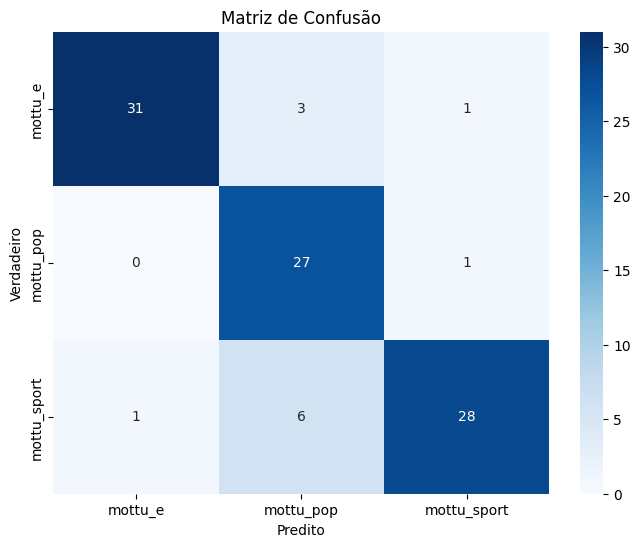

In [ ]:
def evaluate_model():
    # Ensure the model is compiled with necessary metrics if it was loaded without them
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(1e-5), # Using the fine-tuning learning rate for evaluation context
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    # Evaluate on the validation set
    results = model.evaluate(val_generator)
    print("Métricas finais:")
    print(f"Loss: {results[0]:.4f}")
    print(f"Acurácia: {results[1]*100:.2f}%")
    print(f"Precisão: {results[2]*100:.2f}%")
    print(f"Recall: {results[3]*100:.2f}%")

    # Matriz de confusão
    # Ensure class_names are available from the generator
    if hasattr(val_generator, 'class_indices'):
        class_names = list(val_generator.class_indices.keys())
    else:
        # Fallback if class_indices is not available, though it should be for flow_from_directory
        class_names = [str(i) for i in range(NUM_CLASSES)]
        print("Warning: Could not retrieve class names from generator. Using default labels.")


    y_pred = model.predict(val_generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Get true labels from the generator
    y_true = val_generator.classes

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

evaluate_model()

# Salvando o melhor modelo

In [ ]:
model_save_path = os.path.join(dataset_path, "final_model_improved.h5")
model.save(model_save_path)
print(f"Improved model saved to: {model_save_path}")

Improved model saved to: /content/drive/MyDrive/challenge_mottu2025/mottu_dataset/final_model_improved.h5


# Teste

Modelo carregado com sucesso.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


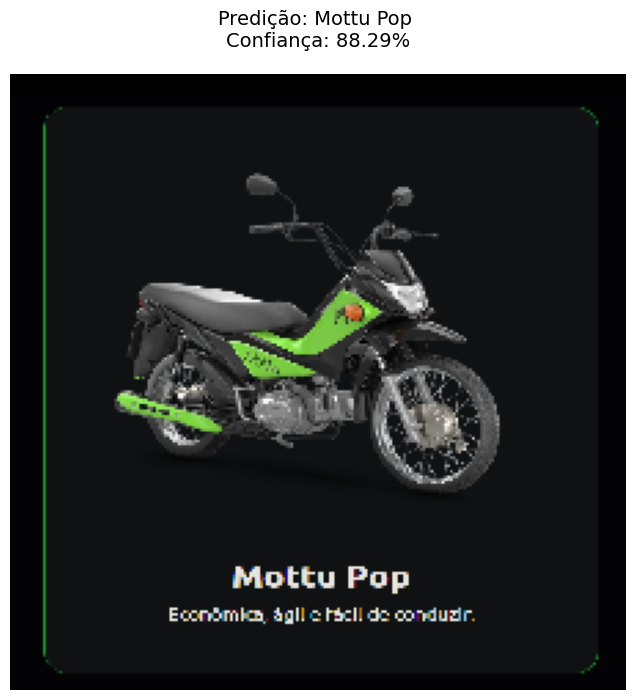

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações do modelo
IMG_SIZE = (224, 224)  # Mesmo usado no treino
dataset_path = "/content/drive/MyDrive/challenge_mottu2025/mottu_dataset"
# Load the improved model
model_path = os.path.join(dataset_path, "final_model_improved.h5")  # Caminho completo

# Carregar modelo (não precisa treinar novamente)
try:
    model = tf.keras.models.load_model(model_path)
    print("Modelo carregado com sucesso.")
except Exception as e:
    print(f"🚨 Erro ao carregar o modelo: {str(e)}")
    model = None # Ensure model is None if loading fails

# Definição da função de predição
def predict_mottu(image_path):
    if model is None:
        print("Não é possível fazer predições: o modelo não foi carregado.")
        return

    try:
        # Verificar existência da imagem
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")

        # Carregar e pré-processar
        img = image.load_img(image_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        # Use the same preprocessing function as during training
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Predição
        pred = model.predict(img_array)
        class_idx = np.argmax(pred[0])

        # Mapeamento de classes (deve corresponder ao usado no treinamento)
        # Ensure this mapping is correct based on the generator's class_indices
        # You might want to load the class_indices from a saved file if you were
        # using a different environment for prediction. Assuming it's consistent here.
        classes = {
            0: 'Mottu E ',
            1: 'Mottu Pop ',
            2: 'Mottu Sport '
        }

        # Plotar resultado
        plt.figure(figsize=(8,8))
        plt.imshow(img) # Display the original image
        plt.title(f"Predição: {classes[class_idx]}\nConfiança: {np.max(pred)*100:.2f}%",
                 fontsize=14, pad=20)
        plt.axis('off')
        plt.show()

    except FileNotFoundError as e:
        print(f"🚨 Erro: {str(e)}")
    except Exception as e:
        print(f"🚨 Ocorreu um erro durante a predição: {str(e)}")

# Caminho para a imagem de teste
test_image = '/content/drive/MyDrive/challenge_mottu2025/Captura de tela 2025-05-20 180112.png' # Use a imagem que você deseja testar

# Chamar a função de predição
predict_mottu(test_image)

# Explicação do Código e Objetivo

Este notebook tem como objetivo treinar e avaliar um modelo de classificação de imagens para identificar diferentes tipos de motocicletas Mottu.

O processo é dividido nas seguintes etapas:

1.  **Configuração do Ambiente:** Montagem do Google Drive para acessar o dataset e definição de constantes como tamanho da imagem, tamanho do lote e número de épocas.
2.  **Pré-processamento e Aumento de Dados:** Utilização do `ImageDataGenerator` do Keras para carregar as imagens e aplicar técnicas de aumento de dados (rotação, zoom, etc.) para melhorar a robustez do modelo. O `preprocess_input` do EfficientNet é usado para preparar as imagens para o modelo pré-treinado.
3.  **Geração de Dados:** Criação de geradores de dados para os conjuntos de treino e validação, lendo as imagens diretamente dos diretórios. A distribuição das classes nos conjuntos de treino e validação é verificada para entender o balanceamento dos dados.
4.  **Visualização de Amostras:** Uma função é definida para plotar exemplos de imagens aumentadas, permitindo visualizar o efeito das transformações aplicadas.
5.  **Definição de Callbacks:** Configuração de callbacks importantes para o treinamento:
    *   `EarlyStopping`: Para interromper o treinamento quando a perda de validação parar de diminuir, evitando overfitting.
    *   `LearningRateScheduler`: Para ajustar a taxa de aprendizado durante o treinamento.
    *   `ModelCheckpoint`: Para salvar os pesos do modelo que resultaram na melhor acurácia de validação.
6.  **Construção do Modelo:** (Embora o código para a construção exata do modelo EfficientNet não esteja presente nas células fornecidas, a estrutura do treinamento em duas fases indica o uso de um modelo base pré-treinado, provavelmente o EfficientNetB0, com camadas personalizadas adicionadas no topo).
7.  **Treinamento em Duas Fases:** O treinamento é realizado em duas fases:
    *   **Fase 1:** Treinamento das camadas personalizadas (head) com as camadas do modelo base congeladas. Isso permite que as novas camadas aprendam a mapear as características extraídas pelo modelo pré-treinado para as classes específicas do problema.
    *   **Fase 2:** Fine-tuning, onde as últimas camadas do modelo base são descongeladas e treinadas junto com as camadas personalizadas com uma taxa de aprendizado menor. Isso permite que o modelo se adapte melhor aos dados específicos do dataset.
8.  **Avaliação Detalhada:** Uma função é definida para avaliar o desempenho final do modelo no conjunto de validação. Métricas como perda, acurácia, precisão e recall são calculadas e uma matriz de confusão é gerada para visualizar o desempenho por classe.
9.  **Salvamento do Modelo:** O modelo treinado e avaliado é salvo em formato HDF5 (`.h5`).
10. **Predição com o Modelo Salvo:** O modelo salvo é carregado e uma função é definida para fazer predições em novas imagens. A imagem de teste é carregada, pré-processada (usando a mesma função de pré-processamento do treinamento) e a classe predita com sua confiança é exibida.

**Objetivo:**

O objetivo principal deste notebook é construir um modelo de deep learning capaz de classificar imagens de motocicletas Mottu em três categorias distintas ('Mottu E', 'Mottu Pop', 'Mottu Sport') com alta acurácia, utilizando técnicas de transferência de aprendizado e aumento de dados para lidar com um dataset limitado.